In [1]:
import numpy as np
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os

import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

### Compute embeddings. 

In [4]:
# Set data directory.
data_dir = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'

# Set layer. 
# 22 = MaxPool_1
# 19 = MaxPool_2
# 14 = MaxPool_3
# 9 = MaxPool_4
# 4 = MaxPool_5
# 2 = fc1
# 1 = fc2
layer_num = 1

# Classify? (0/1): 
classify = 0

# Load pre-trained model.
embeddings_dictionary = {}
yourpath =  data_dir + 'objects/' + 'Assets_actual'
model = VGG19(weights = 'imagenet', include_top= True, input_shape=(224,224,3))

# Remove all layers above target layer.
model2 = Sequential()
for layer in model.layers[:-layer_num]:
    model2.add(layer)
    
# Check what layers are included.
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [111]:
objects = []
embeddings = []
images = []
top_labels = []

f = open("image_paths.txt", "w")

# Run forward pass for each object. 
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in sorted(files):
        
        image_name = yourpath + '/' + name
        f.write(image_name)
        f.write('\n')
        print(name[:-4])
        
        image = load_img(image_name, target_size=(224, 224)); images.append(image)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        
        ## Run predictions.
        
        # Reduced model. 
        yhat = model2.predict(image)
        
        # Full model. 
        yhat_full = model.predict(image)
        
        # Output the top-5 likely labels (of the 1000 in ILSVRC).
        if classify:
            x = decode_predictions(yhat_full)
            top_5 = [k[1] for k in x[0]]
            top_5_conf = [k[2] for k in x[0]]
            top = top_5[0]; top_labels.append(tuple(top_5))
            print('[TOP-5]', top_5)
            print('[TOP-5-confidence]', top_5_conf)
            print('\n')
        
        # Store embedding by flattening and concatenating all maps.
        if ((layer_num == 1) | (layer_num == 2)):
            embeddings_dictionary[name[:-4]] = yhat.reshape(-1,1)
        else: 
            embeddings_dictionary[name[:-4]] = np.mean(yhat, axis=3).reshape(-1,1).T
        
        objects.append(name[:-4])
        embeddings.append(yhat.reshape(-1,1))
        
f.close()

Airplane
Allergy Pills
Apple
Bacon
Banana
Beans
Block 1
Block 10
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Book 1
Book 10
Book 11
Book 12
Book 2
Book 3
Book 4
Book 5
Book 6
Book 7
Book 8
Book 9
Bread
Candle
Candlestick
Carrot
Clipboard
Coconut
Coffee
Crayon 1
Crayon 2
Crayon 3
Crayon 4
Crayon 5
Crayon 6
Cup
Cylinder 1
Cylinder 2
Cylinder 3
Cylinder 4
Dodecahedron
Donut 1
Donut 2
Eraser
Gold
Helmet
Juice Box
Key
Knight
Laptop
Left Shoe
Magazine 1
Magazine 2
Marker 1
Marker 2
Marker 3
Marker 4
Milk Carton 1
Milk Carton 2
Milk Carton 3
Mug
Notebook
Oil Bottle 1
Oil Bottle 2
Oil Carafe 1
Oil Carafe 2
Paint Can
Paper Bag
Paper Box
Paper
Pear
Pen
Pencil 1
Pencil 2
Phone
Picture 1
Picture 2
Pills
Pizza Box
Plastic Box 1
Plastic Box 2
Raw meat
Right Shoe
Rubber Duck
Scissors
Smartphone
Soccer Ball
Soda Can
Takeout Box
Tea Box
Teabag
Tomato
Towel
Train
Vase 1
Vase 2
Vase 3
Water Bottle 2
Water Bottle
Yogurt


In [107]:
def plot_images_with_labels(images, labels, size=(16,16), x=8, y=8):

    n_images = len(images)
    print('Number of images: ' + str(n_images))
    
    ix = 1

    plt.figure(figsize=(size[0],size[1]))
    for _ in range(x):
        for _ in range(y):
            # specify subplot and turn of axis
            ax = plt.subplot(x, y, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(images[ix-1])
            plt.title(labels[ix-1])
            ix += 1
    plt.subplots_adjust(wspace=0.5)
    # show the figure
    plt.show()

In [108]:
# Plot images along with top 5 labels (missing last one).
n = 100
# plot_images_with_labels(images[0+n:5+n], top_labels[0+n:5+n], size=(8,10), x=5, y=1)
plot_images_with_labels([images[105]], [top_labels[105]], size=(2,2), x=1, y=1)

IndexError: list index out of range

In [ ]:
# Plot all feature maps.
def plot_feature_maps(yhat, size=(16,16), x=8, y=8):

    n_maps = yhat.shape[3]
    print('Number of maps: ' + str(n_maps))
    
    ix = 1

    plt.figure(figsize=(size[0],size[1]))
    for _ in range(x):
        for _ in range(y):
            # specify subplot and turn of axis
            ax = plt.subplot(x, y, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(yhat[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()
    
plot_feature_maps(yhat, size=(16,16), x=8, y=8)

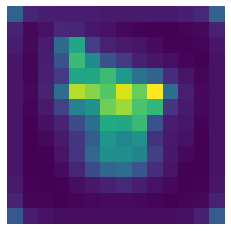

In [112]:
# Visualize averaged feature map.
plt.imshow(np.squeeze(np.mean(yhat, axis=3)),cmap='viridis');
plt.axis('off');

### Store embeddings. 

In [89]:
# Retrieve object names. 
unique_objects = []
for k in embeddings_dictionary:
    unique_objects.append(k)
unique_objects_array = np.asarray(unique_objects)

# Retrieve embeddings.
object_embeddings = []
for k in embeddings_dictionary:
    object_embeddings.append(list(embeddings_dictionary[k].flatten()))
object_embedding_array = np.asarray(object_embeddings)

# Put in dictionary.
embedding_for_vgg = {}
embedding_for_vgg['unique_objects'] = unique_objects_array
embedding_for_vgg['embeddings'] = object_embedding_array

# Save.
fn = data_dir + '/vgg/embeddings/' + layer.name + '.pickle';
    
with open(fn, 'wb') as handle:
    pickle.dump(embedding_for_vgg, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Compute and save similarity. 

In [90]:
pearson_list = []
euclidean_distance_list = []
spearman_list = []

for i in sorted(embeddings_dictionary):
    temp = []
    temp_2 = [] 
    temp_3 = [] 

    for j in sorted(embeddings_dictionary):
        
        embedding_1 = embeddings_dictionary[i].flatten()
        embedding_2 = embeddings_dictionary[j].flatten()
        
        # Pearson correlation.
        pearson_corr = (1-pearsonr(embedding_1,embedding_2)[0])/2
        print('pearson correlation: ' + str(pearson_corr))
        temp.append(pearson_corr)
        
        # Euclidean distance.  
        euclidean_dist = np.linalg.norm(embedding_1-embedding_2)
        print('euclidean distance: ' + str(euclidean_dist))
        temp_2.append(euclidean_dist)
        
        # Spearman correlation.
        spearman_corr = (1-spearmanr(embedding_1,embedding_2)[0])/2
        print('spearman distance: ' + str(spearman_corr))
        temp_3.append(spearman_corr)
        
    pearson_list.append(temp)
    euclidean_distance_list.append(temp_2)
    spearman_list.append(temp_3)
    
sorted_similarity_values_pearson = np.asarray(pearson_list)
sorted_unique_objects_pearson = np.asarray(list(sorted(embeddings_dictionary.keys())))

sorted_similarity_values_euclidean = np.asarray(euclidean_distance_list)
sorted_unique_objects_euclidean = np.asarray(list(sorted(embeddings_dictionary.keys())))

sorted_similarity_values_spearman = np.asarray(spearman_list)
sorted_unique_objects_spearman = np.asarray(list(sorted(embeddings_dictionary.keys())))

pearson correlation: 0.0
euclidean distance: 0.0
spearman distance: 5.551115123125783e-17
pearson correlation: 0.1443487090062341
euclidean distance: 8.25952
spearman distance: 0.151530612244898
pearson correlation: 0.1450351519554517
euclidean distance: 8.830696
spearman distance: 0.14525510204081638
pearson correlation: 0.10666527209634169
euclidean distance: 8.693542
spearman distance: 0.2570918367346939
pearson correlation: 0.1823234794211283
euclidean distance: 10.696963
spearman distance: 0.14025510204081637
pearson correlation: 0.10845992614878369
euclidean distance: 7.1194167
spearman distance: 0.10821428571428571
pearson correlation: 0.08027087838711083
euclidean distance: 6.706612
spearman distance: 0.041275510204081656
pearson correlation: 0.09511615269578944
euclidean distance: 7.1707263
spearman distance: 0.046632653061224494
pearson correlation: 0.09250180747051673
euclidean distance: 6.9856987
spearman distance: 0.049795918367347036
pearson correlation: 0.099998442124915

spearman distance: 0.11250000000000004
pearson correlation: 0.15035899877911763
euclidean distance: 8.831881
spearman distance: 0.09775510204081633
pearson correlation: 0.018510854592887205
euclidean distance: 3.6431713
spearman distance: 0.029336734693877597
pearson correlation: 0.09937858695207946
euclidean distance: 8.128919
spearman distance: 0.1238775510204082
pearson correlation: 0.4288056039873624
euclidean distance: 15.309488
spearman distance: 0.356530612244898
pearson correlation: 0.03291030825271435
euclidean distance: 9.871402
spearman distance: 0.060408163265306125
pearson correlation: 0.15358929069829175
euclidean distance: 8.7619505
spearman distance: 0.10255102040816327
pearson correlation: 0.05584180109736869
euclidean distance: 6.042692
spearman distance: 0.021989795918367416
pearson correlation: 0.029861874619966478
euclidean distance: 5.962575
spearman distance: 0.07698979591836735
pearson correlation: 0.0815049588627706
euclidean distance: 7.5236235
spearman distan

spearman distance: 0.38413265306122446
pearson correlation: 0.11602768141147146
euclidean distance: 4.0123296
spearman distance: 0.26923469387755106
pearson correlation: 0.1597617223910795
euclidean distance: 4.840201
spearman distance: 0.33602040816326534
pearson correlation: 0.22432532632188817
euclidean distance: 8.798315
spearman distance: 0.3280612244897959
pearson correlation: 0.08106285829993776
euclidean distance: 7.114544
spearman distance: 0.26806122448979597
pearson correlation: 0.05361278419334092
euclidean distance: 2.795413
spearman distance: 0.13612244897959191
pearson correlation: 0.07500685186600414
euclidean distance: 10.70614
spearman distance: 0.26535714285714285
pearson correlation: 0.16647983099288816
euclidean distance: 7.755214
spearman distance: 0.31954081632653064
pearson correlation: 0.24100513187823602
euclidean distance: 7.2687306
spearman distance: 0.41892857142857143
pearson correlation: 0.1207730068129726
euclidean distance: 4.3302407
spearman distance: 

spearman distance: 0.01704081632653065
pearson correlation: 0.10148803889192859
euclidean distance: 5.758774
spearman distance: 0.21127551020408164
pearson correlation: 0.049067426489479316
euclidean distance: 5.3891397
spearman distance: 0.10081632653061223
pearson correlation: 0.05250203219790317
euclidean distance: 5.493112
spearman distance: 0.09229591836734696
pearson correlation: 0.05767415891519728
euclidean distance: 5.354867
spearman distance: 0.06862244897959191
pearson correlation: 0.03731812094495368
euclidean distance: 3.573791
spearman distance: 0.08714285714285719
pearson correlation: 0.043241053251545813
euclidean distance: 5.169508
spearman distance: 0.06045918367346942
pearson correlation: 0.12301140814156364
euclidean distance: 6.3876534
spearman distance: 0.21081632653061227
pearson correlation: 0.04018981162730939
euclidean distance: 5.709794
spearman distance: 0.039846938775510266
pearson correlation: 0.09551682415428536
euclidean distance: 7.223337
spearman dista

pearson correlation: 0.05296967626577259
euclidean distance: 3.2467709
spearman distance: 0.07142857142857145
pearson correlation: 0.06215500046653505
euclidean distance: 8.2087145
spearman distance: 0.07357142857142857
pearson correlation: 0.11505797032410109
euclidean distance: 5.3970876
spearman distance: 0.1989285714285714
pearson correlation: 0.12196551239405512
euclidean distance: 5.664395
spearman distance: 0.21474489795918372
pearson correlation: 0.11983739488557255
euclidean distance: 5.4090686
spearman distance: 0.2173469387755102
pearson correlation: 0.1476334204122004
euclidean distance: 6.0636363
spearman distance: 0.20862244897959192
pearson correlation: 0.12951358993619544
euclidean distance: 5.720196
spearman distance: 0.2343367346938776
pearson correlation: 0.138488834127324
euclidean distance: 6.003744
spearman distance: 0.20612244897959187
pearson correlation: 0.05297185736165144
euclidean distance: 3.2252214
spearman distance: 0.058316326530612306
pearson correlatio

spearman distance: 0.13000000000000006
pearson correlation: 0.10678705538996558
euclidean distance: 5.400835
spearman distance: 0.18408163265306127
pearson correlation: 0.13004133627501646
euclidean distance: 5.588706
spearman distance: 0.18755102040816335
pearson correlation: 0.10089488530998691
euclidean distance: 5.2858477
spearman distance: 0.1278571428571429
pearson correlation: 0.09968750119876002
euclidean distance: 5.063308
spearman distance: 0.1844897959183674
pearson correlation: 0.07634083928890034
euclidean distance: 4.8630514
spearman distance: 0.0887244897959184
pearson correlation: 0.07231663944681443
euclidean distance: 4.4829655
spearman distance: 0.17005102040816328
pearson correlation: 0.04908857735343619
euclidean distance: 4.540549
spearman distance: 0.08137755102040817
pearson correlation: 0.09920144555504096
euclidean distance: 5.814473
spearman distance: 0.059438775510204156
pearson correlation: 0.04909533704611685
euclidean distance: 5.8819785
spearman distance

spearman distance: 0.06867346938775515
pearson correlation: 0.12940874701673466
euclidean distance: 5.843341
spearman distance: 0.1937244897959184
pearson correlation: 0.11704436628818982
euclidean distance: 5.7086987
spearman distance: 0.2118367346938776
pearson correlation: 0.11382915774788654
euclidean distance: 5.6274805
spearman distance: 0.21484693877551025
pearson correlation: 0.1720781898268557
euclidean distance: 6.713674
spearman distance: 0.20535714285714285
pearson correlation: 0.15013646483517773
euclidean distance: 6.3001814
spearman distance: 0.22750000000000004
pearson correlation: 0.15487892140488874
euclidean distance: 6.472525
spearman distance: 0.2014795918367347
pearson correlation: 0.0560743824993204
euclidean distance: 3.5224235
spearman distance: 0.04596938775510212
pearson correlation: 0.056472416885648746
euclidean distance: 4.9624896
spearman distance: 0.13331632653061232
pearson correlation: 0.12422147897467828
euclidean distance: 5.091693
spearman distance:

spearman distance: 0.08494897959183678
pearson correlation: 0.08353592245142472
euclidean distance: 8.872791
spearman distance: 0.08505102040816326
pearson correlation: 0.14353161149628596
euclidean distance: 5.9318066
spearman distance: 0.21474489795918372
pearson correlation: 0.14669392104464113
euclidean distance: 6.1261115
spearman distance: 0.23040816326530617
pearson correlation: 0.14647915343327778
euclidean distance: 5.7419944
spearman distance: 0.23285714285714287
pearson correlation: 0.18217538286799084
euclidean distance: 6.576195
spearman distance: 0.22484693877551026
pearson correlation: 0.1627619552314331
euclidean distance: 6.27414
spearman distance: 0.24612244897959185
pearson correlation: 0.16556623118527314
euclidean distance: 6.4642596
spearman distance: 0.22142857142857147
pearson correlation: 0.05808976306102931
euclidean distance: 3.3602667
spearman distance: 0.060918367346938784
pearson correlation: 0.11276225365726389
euclidean distance: 5.540301
spearman distan

spearman distance: 0.06056122448979595
pearson correlation: 0.10520539155865527
euclidean distance: 6.0112834
spearman distance: 0.11117346938775513
pearson correlation: 0.10247228853293866
euclidean distance: 4.9933047
spearman distance: 0.1855102040816327
pearson correlation: 0.057915674619288926
euclidean distance: 5.9943185
spearman distance: 0.06607142857142856
pearson correlation: 0.08687121850489887
euclidean distance: 6.4330206
spearman distance: 0.1504591836734694
pearson correlation: 0.18052675076958657
euclidean distance: 6.627668
spearman distance: 0.219030612244898
pearson correlation: 0.07861244015286795
euclidean distance: 5.554175
spearman distance: 0.08653061224489805
pearson correlation: 0.11756552105952556
euclidean distance: 7.6288075
spearman distance: 0.06117346938775514
pearson correlation: 0.13551194673093037
euclidean distance: 6.75022
spearman distance: 0.09295918367346945
pearson correlation: 0.1071992918650887
euclidean distance: 7.8670993
spearman distance:

spearman distance: 0.14301020408163273
pearson correlation: 0.04598738101676664
euclidean distance: 3.3026931
spearman distance: 0.04770408163265305
pearson correlation: 0.20049109844948565
euclidean distance: 7.5664573
spearman distance: 0.1366836734693878
pearson correlation: 0.10769297883473516
euclidean distance: 5.769939
spearman distance: 0.1635204081632654
pearson correlation: 0.08471439755023158
euclidean distance: 5.322133
spearman distance: 0.17260204081632657
pearson correlation: 0.0791386247336372
euclidean distance: 4.429016
spearman distance: 0.06117346938775514
pearson correlation: 0.06482731204800174
euclidean distance: 4.4035664
spearman distance: 0.08352040816326534
pearson correlation: 0.06194010016752727
euclidean distance: 3.9619975
spearman distance: 0.06163265306122451
pearson correlation: 0.06847022114722412
euclidean distance: 4.4571285
spearman distance: 0.07908163265306128
pearson correlation: 0.21235931036630668
euclidean distance: 6.868969
spearman distance

euclidean distance: 3.8106952
spearman distance: 0.15219387755102043
pearson correlation: 0.04667296568754831
euclidean distance: 12.790229
spearman distance: 0.06244897959183682
pearson correlation: 0.10616064640688355
euclidean distance: 6.467308
spearman distance: 0.04464285714285715
pearson correlation: 0.05197088088805957
euclidean distance: 3.156677
spearman distance: 0.0697448979591837
pearson correlation: 0.04334777436816756
euclidean distance: 2.7937193
spearman distance: 0.030408163265306154
pearson correlation: 0.22382389099659272
euclidean distance: 8.55622
spearman distance: 0.22658163265306125
pearson correlation: 0.04201943156960558
euclidean distance: 5.4973025
spearman distance: 0.05326530612244906
pearson correlation: 0.11443925402292204
euclidean distance: 4.4539857
spearman distance: 0.16908163265306125
pearson correlation: 0.04053375648611507
euclidean distance: 9.114989
spearman distance: 0.05346938775510207
pearson correlation: 0.0853162449573327
euclidean distan

spearman distance: 0.27872448979591835
pearson correlation: 0.05361532284482795
euclidean distance: 2.301519
spearman distance: 0.05607142857142866
pearson correlation: 0.1581362917023531
euclidean distance: 3.6114295
spearman distance: 0.20183673469387753
pearson correlation: 0.07349229499921606
euclidean distance: 8.5112295
spearman distance: 0.0563775510204082
pearson correlation: 0.286755320292194
euclidean distance: 5.549061
spearman distance: 0.3175510204081633
pearson correlation: 0.37820511197761647
euclidean distance: 6.907069
spearman distance: 0.37739795918367347
pearson correlation: 0.41698574959056545
euclidean distance: 9.485094
spearman distance: 0.41872448979591836
pearson correlation: 0.19566955923802576
euclidean distance: 4.886937
spearman distance: 0.20545918367346944
pearson correlation: 0.11698476278504644
euclidean distance: 3.2748156
spearman distance: 0.07780612244897966
pearson correlation: 0.07937066045525776
euclidean distance: 3.5325983
spearman distance: 0

spearman distance: 0.11663265306122456
pearson correlation: 0.14396103141624983
euclidean distance: 4.398744
spearman distance: 0.10852040816326536
pearson correlation: 0.21044171964593927
euclidean distance: 5.814922
spearman distance: 0.08724489795918372
pearson correlation: 0.1153631252807219
euclidean distance: 5.454177
spearman distance: 0.09137755102040823
pearson correlation: 0.17674263509591293
euclidean distance: 5.236181
spearman distance: 0.07423469387755105
pearson correlation: 0.16222380615195608
euclidean distance: 5.4154105
spearman distance: 0.23959183673469392
pearson correlation: 0.04686858606165101
euclidean distance: 2.5941217
spearman distance: 0.03397959183673477
pearson correlation: 0.1905536238766276
euclidean distance: 4.7126765
spearman distance: 0.13306122448979596
pearson correlation: 0.08841028232957532
euclidean distance: 8.042877
spearman distance: 0.0753571428571429
pearson correlation: 0.27326079798951863
euclidean distance: 6.0212855
spearman distance:

spearman distance: 0.07821428571428574
pearson correlation: 0.0796406739074661
euclidean distance: 8.132726
spearman distance: 0.07362244897959186
pearson correlation: 0.06634608296878752
euclidean distance: 4.9304285
spearman distance: 0.11377551020408172
pearson correlation: 0.07820534312695437
euclidean distance: 5.865714
spearman distance: 0.108265306122449
pearson correlation: 0.2943725522296825
euclidean distance: 8.983562
spearman distance: 0.3295918367346939
pearson correlation: 0.2736976667346743
euclidean distance: 8.888079
spearman distance: 0.2566326530612245
pearson correlation: 0.09923198449371573
euclidean distance: 5.355528
spearman distance: 0.11826530612244901
pearson correlation: 0.2494739955441994
euclidean distance: 8.966871
spearman distance: 0.1750000000000001
pearson correlation: 0.10689331356883264
euclidean distance: 6.0808487
spearman distance: 0.11265306122448987
pearson correlation: 0.08824987451678934
euclidean distance: 5.4400935
spearman distance: 0.1376

spearman distance: 0.14474489795918366
pearson correlation: 0.2770170494239007
euclidean distance: 9.148351
spearman distance: 0.08275510204081632
pearson correlation: 0.24426734981004605
euclidean distance: 10.630888
spearman distance: 0.11913265306122456
pearson correlation: 0.18994862980685145
euclidean distance: 5.9956346
spearman distance: 0.3477551020408164
pearson correlation: 0.27252276813208165
euclidean distance: 12.2066965
spearman distance: 0.3087244897959184
pearson correlation: 0.10027019397003567
euclidean distance: 5.559961
spearman distance: 0.07045918367346948
pearson correlation: 0.08845676727321794
euclidean distance: 4.3768787
spearman distance: 0.09346938775510205
pearson correlation: 0.13026423481834376
euclidean distance: 5.1145854
spearman distance: 0.10500000000000004
pearson correlation: 0.09843425519151788
euclidean distance: 4.6159167
spearman distance: 0.09637755102040818
pearson correlation: 0.21815045612989625
euclidean distance: 6.0992513
spearman dista

spearman distance: 0.4138265306122449
pearson correlation: 0.3485182735693668
euclidean distance: 6.410474
spearman distance: 0.29408163265306125
pearson correlation: 0.1405674790650019
euclidean distance: 5.228754
spearman distance: 0.13969387755102042
pearson correlation: 0.1470964092818835
euclidean distance: 7.249364
spearman distance: 0.07714285714285718
pearson correlation: 0.18334233523035232
euclidean distance: 6.5462036
spearman distance: 0.22102040816326535
pearson correlation: 0.07306906744392766
euclidean distance: 5.9241934
spearman distance: 0.04158163265306125
pearson correlation: 0.18118379750881192
euclidean distance: 7.0353928
spearman distance: 0.17530612244897964
pearson correlation: 0.17192538360712106
euclidean distance: 7.5826225
spearman distance: 0.2062755102040817
pearson correlation: 0.13069329514318484
euclidean distance: 5.1046658
spearman distance: 0.1774489795918368
pearson correlation: 0.14755435144396567
euclidean distance: 4.851548
spearman distance: 0

KeyboardInterrupt: 

In [82]:
similarity_vgg_pearson = {}
similarity_vgg_pearson['unique_objects'] = sorted_unique_objects_pearson
similarity_vgg_pearson['similarity_matrix'] = sorted_similarity_values_pearson

similarity_vgg_euclidean = {}
similarity_vgg_euclidean['unique_objects'] = sorted_unique_objects_euclidean
similarity_vgg_euclidean['similarity_matrix'] = sorted_similarity_values_euclidean

similarity_vgg_spearman = {}
similarity_vgg_spearman['unique_objects'] = sorted_unique_objects_spearman
similarity_vgg_spearman['similarity_matrix'] = sorted_similarity_values_spearman

# Save.
fn_p = data_dir + 'vgg/similarity/' + layer.name + '_pearson_distance.pickle';
fn_e = data_dir + 'vgg/similarity/' + layer.name + '_euclidean_distance.pickle';
fn_s = data_dir + 'vgg/similarity/' + layer.name + '_spearman_distance.pickle';

with open(fn_p, 'wb') as handle:
    pickle.dump(similarity_vgg_pearson, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(fn_e, 'wb') as handle:
    pickle.dump(similarity_vgg_euclidean, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(fn_s, 'wb') as handle:
    pickle.dump(similarity_vgg_spearman, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot. 

In [62]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z = pearson_list,
                   x= list(sorted(embeddings_dictionary.keys())),
                   y=list(sorted(embeddings_dictionary.keys())),
                   hoverongaps = False))
fig.show()